### 토큰화

In [3]:
pip show pyLDAvi

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from konlpy.tag import Okt

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\USER\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv("data_test.csv", encoding = "utf-8-sig")
df = df[["review"]]
df

review
0      스픽해지 안되는건가요? 위에 설명대로 들어가서 구독취소해서 완료는 된것같은ㄷ니ㅣ 아...
1      블로 아시는 분! 도와주세요 블로 정기 주간으로 결제를 했고 취소했어야 했는데 깜박...
2      암웨이 질문드려요. 제가 먹을려구요. 40대 남입니다. 암웨이 뉴트리라이트 맨즈 에...
3      과학소년 정기구독하시는 분 4월호 배송왔나요? 오늘쯤 와야하는데 안온다고 아들이 언...
4      우유 대신 아몬드브리즈,두유 드시는분 계신가여?ㅠㅠ 저요 아몬드브리즈요. 네~저는 ...
...                                                  ...
9996   커피부작용있으신 분들은 어떤게 가장 힘드세요? 두근거림? 불면증? 뭔가요? 눈떨림이...
9997   임신 15주타 불면증 생김 해외라 지금 새벽 3시에요 남편이 첫째랑 같이 자고 저는...
9998   족욕기가 숙면에 도움을 주나요? 스팀 족욕기가 눈에 띄길래 불면에 좋을지 궁금합니다...
9999   새벽에 자다깨는것도 불면증인가요.. 머리만대면 자는스타일인데 요새 부쩍 2시.3시쯤...
10000  불만을 이렇게 얘기하는거 어떻게 생각하시는지 궁금해요 1. 2. 3. 4. 5. …...

[10001 rows x 1 columns]

In [3]:
okt = Okt()
tqdm.pandas()

df["token"] = df["review"].progress_apply(lambda x : okt.morphs(x, stem = True))

100%|██████████| 10001/10001 [08:22<00:00, 19.92it/s]


### 임베딩

In [4]:
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import doc2vec

# doc2vec
tagged_corpus_list = []

for index, row in tqdm(df.iterrows()):
    text = row['token']
    tag = "document {}".format(index)
    tagged_corpus_list.append(TaggedDocument(tags=[tag], words = text))
print('문서의 수 :', len(tagged_corpus_list))

10001it [00:00, 18849.13it/s]

문서의 수 : 10001


In [5]:
tagged_corpus_list[0]

TaggedDocument(words=['스픽해', '지', '안되다', '가요', '?', '위', '에', '설명', '대로', '들어가다', '구독', '취소', '하다', '완료', '는', '되다', '같다', 'ㄷ', '니', 'ㅣ', '아래', '에', '저', '12', '개월', '할부', '는', '계속', '내야', '하다', '가요', '?', '요금', '결재', '가', '계속', '되다', 'ㅠㅠ', '이', '거', '는', '12', '개월', '다', '내다', '가요', '?', '스픽', '정기', '결제', '취소', '검색', '하다', '방법', '나오다', '.'], tags=['document 0'])

In [6]:
doc2vec_model = doc2vec.Doc2Vec(vector_size=30, alpha=0.025, min_alpha=0.025, workers=8, window=8)

# Vocabulary 빌드
doc2vec_model.build_vocab(tagged_corpus_list)

# Doc2Vec 학습
doc2vec_model.train(tagged_corpus_list, total_examples=doc2vec_model.corpus_count, epochs = 10)

In [7]:
doc2vec_model.dv.get_vector("document 1", norm=True)

array([ 0.28606156, -0.06175774,  0.25970942,  0.21416189,  0.36613473,
        0.00711243,  0.06424004, -0.10009366, -0.41715276, -0.22815199,
       -0.12645972,  0.17144267, -0.15100147,  0.12338081, -0.16362616,
        0.25526533,  0.07028779, -0.26275674, -0.10984242,  0.10047053,
       -0.10765591, -0.11630713, -0.11770882,  0.06693745,  0.11319038,
       -0.11786167,  0.16711529,  0.23881148,  0.00589966,  0.00928291],
      dtype=float32)

In [8]:
vec = [doc2vec_model.dv.get_vector("document {}".format(i), norm=True) for i in df.index]
df["vector"] = vec

### 준지도학습

In [9]:
# 가상 데이터 설정
import random
labeled = df.loc[:1000].reset_index(drop = True)
not_labeled = df.loc[1000:].reset_index(drop = True)
labeled["target"] = [random.choice([0, 1]) for i in labeled.index]
labeled

review  \
0     스픽해지 안되는건가요? 위에 설명대로 들어가서 구독취소해서 완료는 된것같은ㄷ니ㅣ 아...   
1     블로 아시는 분! 도와주세요 블로 정기 주간으로 결제를 했고 취소했어야 했는데 깜박...   
2     암웨이 질문드려요. 제가 먹을려구요. 40대 남입니다. 암웨이 뉴트리라이트 맨즈 에...   
3     과학소년 정기구독하시는 분 4월호 배송왔나요? 오늘쯤 와야하는데 안온다고 아들이 언...   
4     우유 대신 아몬드브리즈,두유 드시는분 계신가여?ㅠㅠ 저요 아몬드브리즈요. 네~저는 ...   
...                                                 ...   
996   당뇨 남편 운동,식단 걱정이네요 40대 중반 남편이 당뇨 초기단계로 약 먹고 있었는...   
997   거꾸리 후 두통이 생기네요 왜그런걸까요 예전엔 거꾸리 해도 그렇지 않았은데 언젠가부...   
998   MBC 에서 건강을 위해 잡곡밥 드시는 분을 찾습니다. MBC 제작진입니다. 저희가...   
999   시어머니 패혈증으로 입원중인데 서울로 전원 추천 vs 비추천 조언 부탁드려요 !!!...   
1000  친정 엄마가 라오스에서 침향을 사오셨는데.. 😑 주의사항 있을까요?? 약은 한국이 ...   

                                                  token  \
0     [스픽해, 지, 안되다, 가요, ?, 위, 에, 설명, 대로, 들어가다, 구독, 취...   
1     [블, 로, 아시, 는, 분, !, 도와주다, 블, 로, 정기, 주간, 으로, 결제...   
2     [암웨이, 질문, 드리다, ., 제, 가, 먹다, 구, 요, ., 40, 대다, 남...   
3     [과학소년, 정기, 구독, 하다, 분, 4월, 호, 배송, 오다, ?, 오늘, 쯤,...   
4     [우유, 대신, 아몬드, 브리, 즈, ,, 두유, 들다, 분, 계시다, ?, ㅠㅠ,...   
...                                                 ...   
996   [당뇨, 남편, 운동, ,, 식단, 걱정, 이네, 요, 40, 대다, 중반, 남편,...   
997   [거, 꾸리, 후, 두통, 이, 생기다, 왜, 그런, 걸, 끄다, 예전, 엔, 거,...   
998   [MBC, 에서, 건강, 을, 위해, 잡곡, 밥, 들다, 분, 을, 찾다, ., M...   
999   [시어머니, 패혈증, 으로, 입원, 중, 인데, 서울, 로, 전원, 추천, vs, ...   
1000  [친정, 엄마, 가, 라오스, 에서, 침향, 을, 사오다, .., 😑, 주의, 사항...   

                                                 vector  target  
0     [0.18606986, -0.16731831, 0.066572815, 0.03801...       0  
1     [0.28606156, -0.061757736, 0.25970942, 0.21416...       0  
2     [0.15185782, -0.14973672, 0.35555366, 0.143945...       0  
3     [0.19468373, 0.06430335, 0.14021803, 0.1664975...       0  
4     [0.13045639, 0.08444959, -0.065647215, 0.08184...       0  
...                                                 ...     ...  
996   [0.5286371, 0.09589513, 0.20890822, 0.22184038...       0  
997   [0.07559114, 0.12936032, 0.080803536, 0.028889...       1  
998   [0.17259657, 0.014999644, 0.30519587, 0.085930...       0  
999   [0.029822191, 0.1578684, 0.13593516, 0.2821058...       1  
1000  [0.121192805, -0.11649181, 0.1279897, 0.175073...       0  

[1001 rows x 4 columns]

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

model1 = RandomForestClassifier()
model2 = SVC()
model3 = LogisticRegression()

x_train = list(labeled["vector"])
y_train = labeled["target"]
x_test = list(not_labeled["vector"])

In [11]:
# 학습
model1.fit(x_train, y_train)
model2.fit(x_train, y_train)

print("Random Forest 점수: ", model1.score(x_train, y_train), "\nSVC 점수: ", model2.score(x_train, y_train))

# 예측
prediction1 = model1.predict(x_test)
prediction2 = model2.predict(x_test)

# 합의
not_labeled["target"] = [i if i == prediction2[a] else 2 for a, i in enumerate(prediction2)]
not_labeled

Random Forest 점수:  1.0 
SVC 점수:  0.7282717282717283


review  \
0     친정 엄마가 라오스에서 침향을 사오셨는데.. 😑 주의사항 있을까요?? 약은 한국이 ...   
1     남편이 소금 푹 찍어먹으면 잔소리하세요? 잔소리로 듣고 듣기싫어하고 안고치는데 말하...   
2     오징어 회 먹구싶은데 엄청 비싸네요 ㅜㅜ 효능 오징어의 효능 9가지 1. 간기능 개...   
3     고혈압이 저혈압으로~ 고혈압이라 약 복용중인데 저혈압으로 바뀔수가 있나요? 약 먹으...   
4     고혈압 혈압으로 진단 받나요? 아니면 정밀 검사 해야하나요? 그냥 혈압 재서요......   
...                                                 ...   
8996  커피부작용있으신 분들은 어떤게 가장 힘드세요? 두근거림? 불면증? 뭔가요? 눈떨림이...   
8997  임신 15주타 불면증 생김 해외라 지금 새벽 3시에요 남편이 첫째랑 같이 자고 저는...   
8998  족욕기가 숙면에 도움을 주나요? 스팀 족욕기가 눈에 띄길래 불면에 좋을지 궁금합니다...   
8999  새벽에 자다깨는것도 불면증인가요.. 머리만대면 자는스타일인데 요새 부쩍 2시.3시쯤...   
9000  불만을 이렇게 얘기하는거 어떻게 생각하시는지 궁금해요 1. 2. 3. 4. 5. …...   

                                                  token  \
0     [친정, 엄마, 가, 라오스, 에서, 침향, 을, 사오다, .., 😑, 주의, 사항...   
1     [남편, 이, 소금, 푹, 찍다, 먹다, 잔소리, 하다, ?, 잔소리, 로, 듣다,...   
2     [오징어, 회, 먹다, 엄청, 비싸다, ㅜㅜ, 효능, 오징어, 의, 효능, 9, 가...   
3     [고혈압, 이, 저혈압, 으로, ~, 고혈압, 이라, 약, 복용, 중, 인데, 저혈...   
4     [고혈압, 혈압, 으로, 진단, 받다, ?, 아니다, 정밀, 검사, 하다, ?, 그...   
...                                                 ...   
8996  [커피, 부작용, 있다, 분, 들, 은, 어떻다, 가장, 힘들다, ?, 두근거리다,...   
8997  [임신, 15, 주, 타, 불면증, 생기다, 해외, 라, 지금, 새벽, 3시, 에요...   
8998  [족욕, 기, 가, 숙면, 에, 도움, 을, 주다, ?, 스팀, 족욕, 기, 가, ...   
8999  [새벽, 에, 자다, 깨다, 불면증, 인가요, .., 머리, 만, 대면, 자다, 스...   
9000  [불만, 을, 이렇게, 얘기, 하다, 어떻다, 생각, 하다, 궁금하다, 1, ., ...   

                                                 vector  target  
0     [0.121192805, -0.11649181, 0.1279897, 0.175073...       1  
1     [0.3630867, 0.06351465, -0.09884252, 0.3139136...       1  
2     [-0.104528025, -0.12641427, 0.45471883, 0.1198...       1  
3     [0.0060129524, 0.104009286, 0.14471875, -0.003...       0  
4     [0.26024228, -0.2035343, 0.122771785, 0.001972...       1  
...                                                 ...     ...  
8996  [0.17538287, -0.11458622, 0.12969698, 0.058991...       1  
8997  [-0.090990745, -0.18192104, 0.13949925, 0.0302...       1  
8998  [-0.044295482, -0.066080555, 0.17422108, 0.169...       1  
8999  [-0.020262685, 0.10093191, 0.02719871, -0.0656...       0  
9000  [0.14400545, 0.085857235, 0.4045665, 0.0782453...       1  

[9001 rows x 4 columns]

In [12]:
# 업데이트
new_labeled = not_labeled[not_labeled["target"] != 2].reset_index(drop = True)
not_labeled = not_labeled[not_labeled["target"] == 2].reset_index(drop = True)

labeled = pd.concat([labeled, new_labeled], axis = 0).reset_index(drop = True)

x_train = list(labeled["vector"])
y_train = labeled["target"]
x_test = list(not_labeled["vector"])

In [15]:
# 최종 예측
model3.fit(x_train, y_train)

print("Logistic Regression 점수: ", model3.score(x_train, y_train))

# 예측
not_labeled["target"] = model3.predict(x_test)

# 최종 업데이트
df = pd.concat([labeled, not_labeled], axis = 0).reset_index(drop = True)

Logistic Regression 점수:  0.7856428714257149


### 시각화 및 Actor 도출

In [9]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(np.array(list(df["vector"]), dtype = object))

# 주성분으로 이루어진 데이터 프레임 구성
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
principalDf

principal component1  principal component2
0                 -0.001755              0.134322
1                  0.104328              0.025860
2                  0.193361             -0.052647
3                  0.094179              0.116312
4                 -0.333789             -0.282898
...                     ...                   ...
9996              -0.391804             -0.231868
9997              -0.096751              0.086824
9998              -0.212563             -0.094813
9999              -0.264738              0.004159
10000              0.347898              0.099928

[10001 rows x 2 columns]

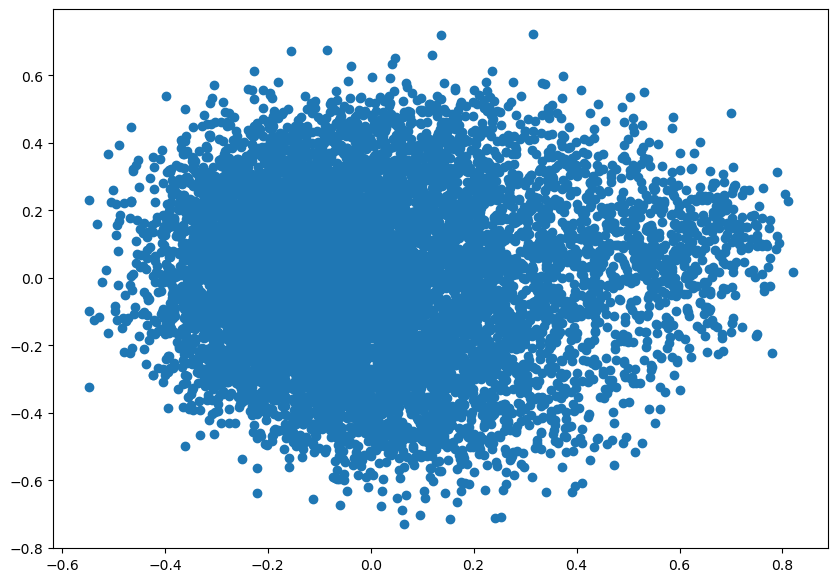

In [10]:
plt.figure(figsize=(10, 7))
plt.scatter(principalDf["principal component1"],principalDf["principal component2"])
plt.show()

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score

In [12]:
k = 3
model = KMeans(n_clusters = k)
model.fit(np.array(list(df["vector"]), dtype = object))
df['kmeans'] = model.fit_predict(np.array(list(df["vector"]), dtype = object))
df

review  \
0      스픽해지 안되는건가요? 위에 설명대로 들어가서 구독취소해서 완료는 된것같은ㄷ니ㅣ 아...   
1      블로 아시는 분! 도와주세요 블로 정기 주간으로 결제를 했고 취소했어야 했는데 깜박...   
2      암웨이 질문드려요. 제가 먹을려구요. 40대 남입니다. 암웨이 뉴트리라이트 맨즈 에...   
3      과학소년 정기구독하시는 분 4월호 배송왔나요? 오늘쯤 와야하는데 안온다고 아들이 언...   
4      우유 대신 아몬드브리즈,두유 드시는분 계신가여?ㅠㅠ 저요 아몬드브리즈요. 네~저는 ...   
...                                                  ...   
9996   커피부작용있으신 분들은 어떤게 가장 힘드세요? 두근거림? 불면증? 뭔가요? 눈떨림이...   
9997   임신 15주타 불면증 생김 해외라 지금 새벽 3시에요 남편이 첫째랑 같이 자고 저는...   
9998   족욕기가 숙면에 도움을 주나요? 스팀 족욕기가 눈에 띄길래 불면에 좋을지 궁금합니다...   
9999   새벽에 자다깨는것도 불면증인가요.. 머리만대면 자는스타일인데 요새 부쩍 2시.3시쯤...   
10000  불만을 이렇게 얘기하는거 어떻게 생각하시는지 궁금해요 1. 2. 3. 4. 5. …...   

                                                   token  \
0      [스픽해, 지, 안되다, 가요, ?, 위, 에, 설명, 대로, 들어가다, 구독, 취...   
1      [블, 로, 아시, 는, 분, !, 도와주다, 블, 로, 정기, 주간, 으로, 결제...   
2      [암웨이, 질문, 드리다, ., 제, 가, 먹다, 구, 요, ., 40, 대다, 남...   
3      [과학소년, 정기, 구독, 하다, 분, 4월, 호, 배송, 오다, ?, 오늘, 쯤,...   
4      [우유, 대신, 아몬드, 브리, 즈, ,, 두유, 들다, 분, 계시다, ?, ㅠㅠ,...   
...                                                  ...   
9996   [커피, 부작용, 있다, 분, 들, 은, 어떻다, 가장, 힘들다, ?, 두근거리다,...   
9997   [임신, 15, 주, 타, 불면증, 생기다, 해외, 라, 지금, 새벽, 3시, 에요...   
9998   [족욕, 기, 가, 숙면, 에, 도움, 을, 주다, ?, 스팀, 족욕, 기, 가, ...   
9999   [새벽, 에, 자다, 깨다, 불면증, 인가요, .., 머리, 만, 대면, 자다, 스...   
10000  [불만, 을, 이렇게, 얘기, 하다, 어떻다, 생각, 하다, 궁금하다, 1, ., ...   

                                                  vector  kmeans  
0      [0.0690372, -0.0081945425, 0.058666617, 0.0813...       1  
1      [0.24506694, 0.024255255, 0.14741307, 0.126980...       1  
2      [0.11152799, 0.0909238, 0.2516572, 0.111148454...       2  
3      [0.17597015, 0.13747522, 0.0449083, 0.17280678...       1  
4      [0.11052332, -0.12362151, 0.2485145, 0.1456268...       2  
...                                                  ...     ...  
9996   [0.07075282, -0.062491607, 0.37163424, 0.19467...       2  
9997   [0.068282604, 0.038101994, 0.11005651, -0.1128...       1  
9998   [0.16607445, 0.0007859725, 0.15364432, -0.0084...       2  
9999   [0.054637033, 0.15579161, 0.06023832, 0.109330...       1  
10000  [0.28886086, 0.19131954, 0.2569727, -0.0178849...       0  

[10001 rows x 4 columns]

100%|██████████| 10001/10001 [03:13<00:00, 51.79it/s]


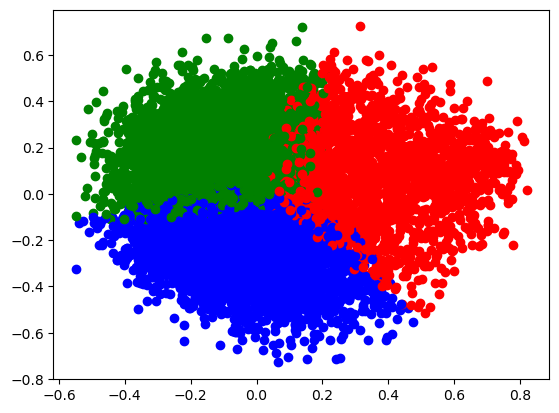

In [13]:
color = ["red", "green", "blue"]
principalDf["kmeans"] = df['kmeans']
for i in tqdm(principalDf.index):
    plt.scatter(principalDf["principal component1"].loc[i],
                principalDf["principal component2"].loc[i],
                color = color[principalDf["kmeans"].loc[i]])

100%|██████████| 8/8 [00:42<00:00,  5.25s/it]


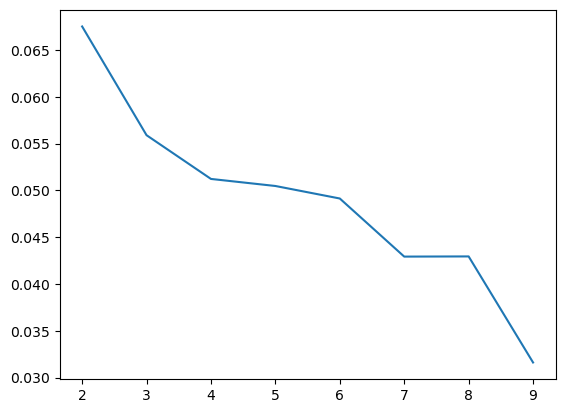

In [14]:
result = []
for i in tqdm(range(2, 10)):
    model = KMeans(n_clusters = i)
    model.fit(np.array(list(df["vector"]), dtype = object))
    temp = model.fit_predict(np.array(list(df["vector"]), dtype = object))
    result.append(silhouette_score(np.array(list(df["vector"]), dtype = object), temp))
    
plt.plot(range(2, 10), result)

In [15]:
k = 5
model = KMeans(n_clusters = k)
model.fit(np.array(list(df["vector"]), dtype = object))
df['kmeans'] = model.fit_predict(np.array(list(df["vector"]), dtype = object))
df

review  \
0      스픽해지 안되는건가요? 위에 설명대로 들어가서 구독취소해서 완료는 된것같은ㄷ니ㅣ 아...   
1      블로 아시는 분! 도와주세요 블로 정기 주간으로 결제를 했고 취소했어야 했는데 깜박...   
2      암웨이 질문드려요. 제가 먹을려구요. 40대 남입니다. 암웨이 뉴트리라이트 맨즈 에...   
3      과학소년 정기구독하시는 분 4월호 배송왔나요? 오늘쯤 와야하는데 안온다고 아들이 언...   
4      우유 대신 아몬드브리즈,두유 드시는분 계신가여?ㅠㅠ 저요 아몬드브리즈요. 네~저는 ...   
...                                                  ...   
9996   커피부작용있으신 분들은 어떤게 가장 힘드세요? 두근거림? 불면증? 뭔가요? 눈떨림이...   
9997   임신 15주타 불면증 생김 해외라 지금 새벽 3시에요 남편이 첫째랑 같이 자고 저는...   
9998   족욕기가 숙면에 도움을 주나요? 스팀 족욕기가 눈에 띄길래 불면에 좋을지 궁금합니다...   
9999   새벽에 자다깨는것도 불면증인가요.. 머리만대면 자는스타일인데 요새 부쩍 2시.3시쯤...   
10000  불만을 이렇게 얘기하는거 어떻게 생각하시는지 궁금해요 1. 2. 3. 4. 5. …...   

                                                   token  \
0      [스픽해, 지, 안되다, 가요, ?, 위, 에, 설명, 대로, 들어가다, 구독, 취...   
1      [블, 로, 아시, 는, 분, !, 도와주다, 블, 로, 정기, 주간, 으로, 결제...   
2      [암웨이, 질문, 드리다, ., 제, 가, 먹다, 구, 요, ., 40, 대다, 남...   
3      [과학소년, 정기, 구독, 하다, 분, 4월, 호, 배송, 오다, ?, 오늘, 쯤,...   
4      [우유, 대신, 아몬드, 브리, 즈, ,, 두유, 들다, 분, 계시다, ?, ㅠㅠ,...   
...                                                  ...   
9996   [커피, 부작용, 있다, 분, 들, 은, 어떻다, 가장, 힘들다, ?, 두근거리다,...   
9997   [임신, 15, 주, 타, 불면증, 생기다, 해외, 라, 지금, 새벽, 3시, 에요...   
9998   [족욕, 기, 가, 숙면, 에, 도움, 을, 주다, ?, 스팀, 족욕, 기, 가, ...   
9999   [새벽, 에, 자다, 깨다, 불면증, 인가요, .., 머리, 만, 대면, 자다, 스...   
10000  [불만, 을, 이렇게, 얘기, 하다, 어떻다, 생각, 하다, 궁금하다, 1, ., ...   

                                                  vector  kmeans  
0      [0.0690372, -0.0081945425, 0.058666617, 0.0813...       4  
1      [0.24506694, 0.024255255, 0.14741307, 0.126980...       4  
2      [0.11152799, 0.0909238, 0.2516572, 0.111148454...       2  
3      [0.17597015, 0.13747522, 0.0449083, 0.17280678...       4  
4      [0.11052332, -0.12362151, 0.2485145, 0.1456268...       2  
...                                                  ...     ...  
9996   [0.07075282, -0.062491607, 0.37163424, 0.19467...       0  
9997   [0.068282604, 0.038101994, 0.11005651, -0.1128...       1  
9998   [0.16607445, 0.0007859725, 0.15364432, -0.0084...       4  
9999   [0.054637033, 0.15579161, 0.06023832, 0.109330...       4  
10000  [0.28886086, 0.19131954, 0.2569727, -0.0178849...       3  

[10001 rows x 4 columns]

### TF-IDF

In [16]:
from collections import Counter

def count(series):
    res = []
    for i in series:
        for w in i:
            res.append(w)
    return dict(Counter(res))

total = count(df["token"])

local = []
for i in range(k):
    temp = df[df["kmeans"] == i]
    local.append(count(temp["token"]))
local

[{'커피': 1152,
  '정기': 37,
  '구독': 6,
  '좋다': 2591,
  '포켓': 1,
  'CU': 1,
  '여기': 78,
  '서': 563,
  '하다': 17311,
  '~.': 762,
  '구독료': 1,
  '2,000원': 1,
  '에': 8171,
  '30': 277,
  '잔': 204,
  '30%': 5,
  '할인': 13,
  '이': 12193,
  '요': 6873,
  '~': 1836,
  '하루': 890,
  '한잔': 215,
  '씩': 663,
  '한': 1912,
  '달': 909,
  '먹다': 13541,
  '있다': 5659,
  '..': 7534,
  '불고기': 10,
  '는': 4950,
  '언제': 67,
  '맛있다': 232,
  'ㅠ': 2329,
  '요즘': 508,
  '달다': 192,
  '크다': 495,
  '동해': 2,
  '어플': 18,
  '에서': 1298,
  '신청': 9,
  '하고': 1883,
  '90%': 8,
  '쿠폰': 2,
  '까지': 904,
  '주다': 335,
  '??': 347,
  '그래서': 610,
  '바로': 422,
  '사용': 57,
  '간장': 29,
  '밀': 50,
  '키트': 8,
  '받다': 1508,
  '해': 982,
  '가족': 222,
  '들': 1806,
  '모두': 76,
  '엄청': 561,
  '!!': 280,
  '역시': 82,
  '고기': 311,
  '사랑': 19,
  '이네': 229,
  '늘': 229,
  '이다': 1620,
  'ㅎㅎ': 839,
  '.': 26103,
  '그렇다': 2707,
  '지다': 221,
  '우와': 58,
  '너무': 1708,
  '보이다': 202,
  '영': 599,
  '양제': 502,
  '뭐': 556,
  '들다': 3703,
  '?': 3633,
  '원래': 346,
 

In [17]:
result = pd.DataFrame()
for i in tqdm(range(k)):
    temp = local[i]
    tfidf = []
    for w in temp:
        tfidf.append(temp[w]/total[w])
    rslt = pd.DataFrame({"word{}".format(i) : list(temp.keys()), "count{}".format(i) : list(temp.values()), "tfidf{}".format(i) : tfidf})
    rslt = rslt.sort_values(by = "count{}".format(i), ascending = False).reset_index(drop = True).loc[:1000]
    rslt = rslt.sort_values(by = "tfidf{}".format(i), ascending = False).reset_index(drop = True)
    result = pd.concat([result, rslt], axis = 1)
result

100%|██████████| 5/5 [00:00<00:00, 12.50it/s]


word0  count0    tfidf0 word1  count1    tfidf1 word2  count2    tfidf2  \
0       단식     297  0.911043    실신     116  0.920635    산패      79  0.951807   
1      체지방     103  0.903509  대상포진     168  0.865979    컬리      75  0.949367   
2       홈트      89  0.872549  정형외과     118  0.836879    망고     222  0.932773   
3       감량     234  0.863469    마취     199  0.832636    토란      65  0.928571   
4       요요     314  0.835106    결핵     125  0.827815    어묵      66  0.891892   
...    ...     ...       ...   ...     ...       ...   ...     ...       ...   
996     치료     156  0.060985    끊다     233  0.083723    운동     169  0.025059   
997     수술     185  0.058936   양배추     134  0.081757  스트레스      65  0.024724   
998     진료      81  0.058023     밥     200  0.071124    검사     196  0.023400   
999      목     123  0.057882   키우다     122  0.069005    수술      71  0.022619   
1000    비염     111  0.036537    찌다     118  0.066856    증상     113  0.021870   

     word3  count3    tfidf3 word4  count4    tfidf4  
0       이혼     315  0.984375    up      87  0.878788  
1       입양     114  0.974359   mag      82  0.872340  
2      며느리     151  0.967949     ▶     127  0.858108  
3       배려     109  0.964602   출연료      83  0.838384  
4       부모     416  0.947608   테아닌     105  0.801527  
...    ...     ...       ...   ...     ...       ...  
996     효과     197  0.052589    ㅋㅋ     163  0.066179  
997     소화     117  0.048750     살     221  0.066128  
998     처방     138  0.045113  좋아하다     126  0.060172  
999     커피     104  0.038791     ㅋ      88  0.060150  
1000    혈압     114  0.038475   빠지다     187  0.057734  

[1001 rows x 15 columns]

In [18]:
df.to_csv("data_processed.csv", encoding = "utf-8-sig")
result.to_csv("tfidf.csv", encoding = "utf-8-sig")

### Action 뽑기

In [19]:
from gensim import corpora, models

# 대상 Actor 설정
df = df[df["kmeans"] == 0]

lda = list(df["token"])

dictionary = corpora.Dictionary(lda)
corpus = [dictionary.doc2bow(text) for text in lda]

In [20]:
corpus[0:1]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 2),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1)]]

In [21]:
topic_num = 3
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = topic_num, id2word = dictionary)

In [22]:
#토픽당 단어의 갯수 5개
ldamodel.print_topics(num_words=5)

[(0, '0.038*"." + 0.030*"하다" + 0.023*"이" + 0.021*"먹다" + 0.015*"도"'),
 (1, '0.046*"." + 0.025*"하다" + 0.021*"이" + 0.017*"먹다" + 0.014*"도"'),
 (2, '0.040*"." + 0.028*"먹다" + 0.026*"하다" + 0.018*"도" + 0.015*"에"')]

In [23]:
#topic probability distribution
ldamodel.get_document_topics(corpus)[0]

[(0, 0.9735193), (1, 0.012884569), (2, 0.013596113)]

In [24]:
# 토픽 개수 지정
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=ldamodel, texts=lda, dictionary=dictionary,topn=10)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

print('\nPerplexity: ', ldamodel.log_perplexity(corpus))


Coherence Score:  0.3253698815427562

Perplexity:  -6.990762965784811


100%|██████████| 8/8 [02:58<00:00, 22.28s/it]


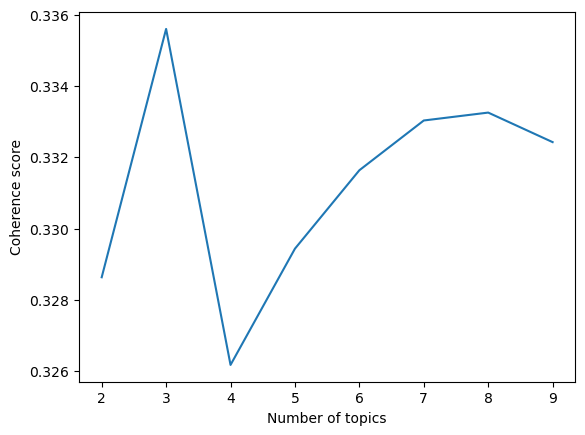

In [25]:
coherence_values = []
for i in tqdm(range(2,10)):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word = dictionary)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=lda, dictionary=dictionary,topn=10) #상위 10개의 단어들을 이용하여 유사도를 알아본다.
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)
    
x = range(2,10)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.show()

100%|██████████| 8/8 [00:50<00:00,  6.36s/it]


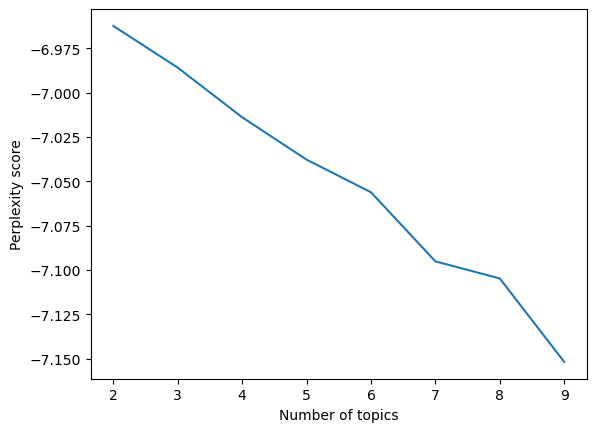

In [26]:
perplexity_values = []
for i in tqdm(range(2,10)):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word = dictionary)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

x = range(2,10)
plt.plot(x, perplexity_values)
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

In [27]:
# 토픽 개수 
topic_num = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = topic_num, id2word = dictionary)

In [28]:
ldamodel.get_document_topics(corpus)[0]

[(4, 0.9725063)]

In [29]:
align = []
for i in ldamodel.get_document_topics(corpus):
    label = []
    value = []
    for w in i:
        label.append(w[0])
        value.append(w[1])
    align.append(label[np.argmax(value)])
align

[4,
 0,
 4,
 1,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 3,
 3,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 0,
 4,
 2,
 4,
 0,
 4,
 4,
 0,
 4,
 3,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 3,
 0,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 0,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 0,
 3,
 4,
 1,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 3,
 4,
 4,
 1,
 4,
 0,
 4,
 4,
 4,
 0,
 4,
 0,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 0,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 4,
 3,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 3,
 3,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 0,
 0,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 3,
 4,
 1,
 4,
 4,
 0,
 4,
 4,
 4,
 0,
 0,
 4,
 2,
 4,
 4,
 4,


In [30]:
df["lda"] = align
df

C:\Users\USER\AppData\Local\Temp\ipykernel_11592\3224990942.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["lda"] = align


review  \
5     커피 정기구독 좋네요 포켓CU 여기서 했어요~. 구독료 2,000원에 30잔 30%...   
66    불고기는 언제 먹어도 맛있 ㅠ 요즘 달려라 큰동해 어플에서 정기구독 신청하고 있는데...   
99    영양제 뭐 드시나요? 원래도 저질 체력이지만 요즘 부쩍 더 느낍니다. 피곤하구요. ...   
102   샐러드 정기구독 하시는분~~~ 정기구독으로 샐러드 드시는분 만족하시나요? 저도 시켜...   
145   풀무원 에어프라이어 쓰시는분? 180도로 안올라가요ㅜㅜ 100도에서 전혀 안올라가요...   
...                                                 ...   
9986  양약 다이어트.. 절실해요ㅠㅠ 경기도권이나 서울쪽도 괜찮아요 유명한곳과 약 잘 드는...   
9987  밤마다 깨는 당신 밤마다 깨는 분 계신가요 제가 그렇네요 시간대는 2시경. 통잠자고...   
9993  중3딸램 건강걱정ㅜ잠이 병적으로 많아요ㅜ 학원가서 수업듣다가 자기도 모르게 존데요ㅜ...   
9995  양약 다이어트 vs 한약 다이어트 9키로 확찐자…도움 받고 싶어요 ㅠㅠ 아니 이렇게...   
9996  커피부작용있으신 분들은 어떤게 가장 힘드세요? 두근거림? 불면증? 뭔가요? 눈떨림이...   

                                                  token  \
5     [커피, 정기, 구독, 좋다, 포켓, CU, 여기, 서, 하다, ~., 구독료, 2...   
66    [불고기, 는, 언제, 먹다, 맛있다, ㅠ, 요즘, 달다, 크다, 동해, 어플, 에...   
99    [영, 양제, 뭐, 들다, ?, 원래, 도, 저, 질, 체력, 이지만, 요즘, 부쩍...   
102   [샐러드, 정기, 구독, 하다, 분, ~~~, 정기, 구독, 으로, 샐러드, 들다,...   
145   [풀무원, 에어, 프라이어, 쓰시, 는, 분, ?, 180, 도로, 안, 올라가다,...   
...                                                 ...   
9986  [양약, 다이어트, .., 절실, 하다, ㅠㅠ, 경기도, 권, 이나, 서, 울, 쪽...   
9987  [밤, 마다, 깨다, 당신, 밤, 마다, 깨다, 분, 계시다, 제, 가, 그렇다, ...   
9993  [중, 3, 딸램, 건강, 걱정, ㅜ, 잠, 이, 병적, 으로, 많다, ㅜ, 학원,...   
9995  [양약, 다이어트, vs, 한약, 다이어트, 9, 키로, 확, 찌다, …, 도움, ...   
9996  [커피, 부작용, 있다, 분, 들, 은, 어떻다, 가장, 힘들다, ?, 두근거리다,...   

                                                 vector  kmeans  lda  
5     [0.19678782, 0.12137206, 0.25399575, 0.1683006...       0    4  
66    [0.29552847, -0.0375047, 0.1804718, 0.33170506...       0    0  
99    [-0.12633859, 0.017311303, -0.002877363, 0.230...       0    4  
102   [0.23445648, -0.18350653, 0.14506648, 0.149899...       0    1  
145   [0.25053725, -0.069130376, 0.0356427, 0.093619...       0    0  
...                                                 ...     ...  ...  
9986  [0.015036471, -0.111333035, 0.08956343, 0.3621...       0    0  
9987  [0.097202145, 0.06391008, 0.16063876, 0.075859...       0    4  
9993  [-0.15765707, 0.14296159, 0.15117826, 0.108898...       0    4  
9995  [0.2715489, -0.14711669, -0.051497977, 0.32595...       0    4  
9996  [0.07075282, -0.062491607, 0.37163424, 0.19467...       0    0  

[1674 rows x 5 columns]

In [31]:
pip install pyLDAvis

In [32]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
prepared_data = gensimvis.prepare(ldamodel, corpus, dictionary, n_jobs = 1)
pyLDAvis.display(prepared_data)
pyLDAvis.save_html(prepared_data, 'ldavis.html')

### opportunity score

In [33]:
# sentiment

import json

with open('SentiWord_info.json', encoding='utf-8-sig', mode='r') as f:
    data = json.load(f)
    
data

[{'word': '(-;', 'word_root': '(', 'polarity': '1'},
 {'word': '(;_;)', 'word_root': '(;_;)', 'polarity': '-1'},
 {'word': '(^^)', 'word_root': '(^^)', 'polarity': '1'},
 {'word': '(^-^)', 'word_root': '(^-^)', 'polarity': '1'},
 {'word': '(^^*', 'word_root': '(', 'polarity': '1'},
 {'word': '(^_^)', 'word_root': '(^_^)', 'polarity': '1'},
 {'word': '(^_^;', 'word_root': '(', 'polarity': '-1'},
 {'word': '(^o^)', 'word_root': '(^o^)', 'polarity': '1'},
 {'word': '(-_-)', 'word_root': '(-_-)', 'polarity': '-1'},
 {'word': '(T_T)', 'word_root': '(T_T)', 'polarity': '-1'},
 {'word': '(ㅡㅡ)', 'word_root': '(', 'polarity': '-1'},
 {'word': ')-:', 'word_root': ')', 'polarity': '-1'},
 {'word': '*^^*', 'word_root': '*', 'polarity': '1'},
 {'word': '/^o^\\', 'word_root': '/', 'polarity': '1'},
 {'word': ':(', 'word_root': ':', 'polarity': '1'},
 {'word': ":'-(", 'word_root': ':', 'polarity': '1'},
 {'word': ':-(', 'word_root': ':', 'polarity': '1'},
 {'word': ':)', 'word_root': ':', 'polarity':

In [34]:
words = []
polarities = []

for i in data:
    words.append(i["word"])
    polarities.append(int(i["polarity"]))

sent_dict = dict(zip(words, polarities))
sent_dict

{'(-;': 1,
 '(;_;)': -1,
 '(^^)': 1,
 '(^-^)': 1,
 '(^^*': 1,
 '(^_^)': 1,
 '(^_^;': -1,
 '(^o^)': 1,
 '(-_-)': -1,
 '(T_T)': -1,
 '(ㅡㅡ)': -1,
 ')-:': -1,
 '*^^*': 1,
 '/^o^\\': 1,
 ':(': 1,
 ":'-(": 1,
 ':-(': 1,
 ':)': -1,
 ':-)': 1,
 ':/': -1,
 ':|': 1,
 ':D': -1,
 ':-D': -1,
 ':p': 0,
 ':-P': -1,
 ';': 1,
 ';)': 1,
 ';-)': 1,
 ';ㅅ;': -1,
 '^///^': 1,
 '^^': 1,
 '^^//': 1,
 '^-^;': -1,
 '^-^;;': -1,
 '^-^;;;;;': -1,
 '-_-^': -1,
 '<3': 1,
 '=)': 1,
 '8-)': 0,
 'B-)': 0,
 'XD': 1,
 'ㄱㅅ': 1,
 'ㄱㅇㄷ': 1,
 '가격이 싸다': 1,
 '가까스로': 0,
 '가까이 사귀어': 1,
 '가까이하다': 1,
 '가꾸러뜨리다': -1,
 '가꾸러트리다': -1,
 '가난': -2,
 '가난뱅이': -2,
 '가난살이': -2,
 '가난살이하다': -2,
 '가난설음': -2,
 '가난에': -2,
 '가난에 쪼들려서': -2,
 '가난하게': -2,
 '가난하고': -2,
 '가난하고 어렵다': -2,
 '가난하고 천한': -2,
 '가난하다': -2,
 '가난하여': -2,
 '가난한': -2,
 '가난한 데다가': -2,
 '가난한 사람을': -2,
 '가난히': -2,
 '가년스럽다': -2,
 '가념하다': -1,
 '가녕스럽다': -2,
 '가누기 어려워하다': -1,
 '가누지 못하고': -2,
 '가누지 못하다': -2,
 '가누지 못할': -2,
 '가누지 못할 정도로': -2,
 '가누지 못함': -2,
 '가눌 수 없게': -2,
 '가눌 수 없을': -2,


In [35]:
def sent_word(token):
    try:
        res = sent_dict[token]
    except:
        res = 0
    return res

In [36]:
sentiment = []
for i in tqdm(range(topic_num)):
    temp = df[df["lda"] == i]
    sent = []
    for w in temp["token"]:
        sent.append(np.mean([sent_word(k) for k in w]))
    sentiment.append(np.mean(sent))    
sentiment

100%|██████████| 5/5 [00:00<00:00, 19.12it/s]


[-0.023784193187897925,
 -0.03244364031410685,
 -0.008867015332160588,
 -0.016267684886875338,
 -0.019423135643015073]

In [37]:
# opportunity
zero = []
one = []
two = []
three = []
four = []

for i in tqdm(ldamodel.get_document_topics(corpus)):
    for w in i:
        if w[0] == 0:
            zero.append(w[1])
        elif w[0] == 1:
            one.append(w[1])
        elif w[0] == 2:
            two.append(w[1])
        elif w[0] == 3:
            three.append(w[1])
        else:
            four.append(w[1])
            
importance = [np.sum(zero)/len(df.index), np.sum(one)/len(df.index), np.sum(two)/len(df.index), np.sum(three)/len(df.index), np.sum(four)/len(df.index)]
importance

100%|██████████| 1674/1674 [00:01<00:00, 1332.13it/s]


[0.25828085549558505,
 0.055616636287639076,
 0.013140283035405933,
 0.03655522755539688,
 0.6323935669382841]

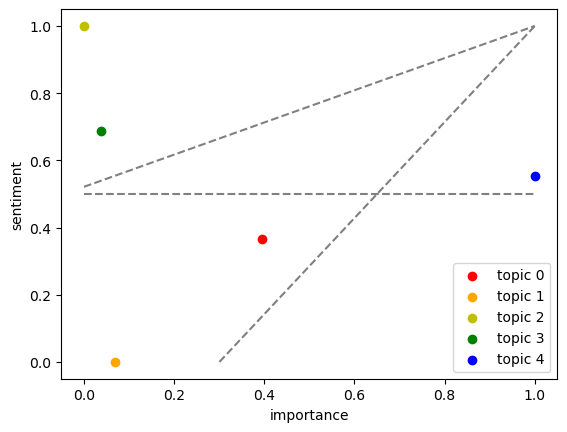

In [38]:
def min_max(series):
    maxx = np.max(series)
    minn = np.min(series)
    return [(i - minn)/(maxx-minn) for i in series]

sentiment = min_max(sentiment)
importance = min_max(importance)

color = ["r", "orange", "y", "g", "blue", "violet"]
for i in range(topic_num):
    plt.scatter(importance[i], sentiment[i], c = color[i], label = "topic {}".format(i))

plt.hlines(0.5, 0, 1, color= 'gray', linestyle= '--')

plt.plot([0, 1], [np.mean(sentiment), 1], color='gray', linestyle='--')
plt.plot([np.mean(importance), 1], [0, 1], color='gray', linestyle='--')
    
plt.xlabel("importance")
plt.ylabel("sentiment")
plt.legend()

### 4D-CX

In [39]:
# 대표 문장 설정

computed = "맞춤형 서비스가 필요해"
connected = "실시간으로 직접 보고 싶어"
shared = "함께 즐기고 싶어"

In [40]:
computed = okt.morphs(computed, stem = True)
connected = okt.morphs(connected, stem = True)
shared = okt.morphs(shared, stem = True)

In [41]:
computed = doc2vec_model.infer_vector(computed)
connected = doc2vec_model.infer_vector(connected)
shared = doc2vec_model.infer_vector(shared)

In [42]:
from scipy import spatial

def cosine_similarity(v1, v2):
    return abs(1 - spatial.distance.cosine(v1, v2))

rep = [computed, connected, shared]

one_zero = sum(df[df["lda"] == 0]["vector"])/len(df[df["lda"] == 0]["vector"].index)
one_one = sum(df[df["lda"] == 1]["vector"])/len(df[df["lda"] == 1]["vector"].index)
one_two = sum(df[df["lda"] == 2]["vector"])/len(df[df["lda"] == 2]["vector"].index)
one_three = sum(df[df["lda"] == 3]["vector"])/len(df[df["lda"] == 3]["vector"].index)
one_four = sum(df[df["lda"] == 4]["vector"])/len(df[df["lda"] == 4]["vector"].index)

real = [one_zero, one_one, one_two, one_three, one_four]

In [43]:
res = []
for i in rep:
    for w in real:
        res.append(cosine_similarity(i, w))
res

[0.7711890339851379,
 0.7696936726570129,
 0.7972359657287598,
 0.7054315805435181,
 0.7496011257171631,
 0.6748785972595215,
 0.6625857949256897,
 0.6966789364814758,
 0.6451130509376526,
 0.6616427302360535,
 0.7894282937049866,
 0.7715544104576111,
 0.7710305452346802,
 0.7496680617332458,
 0.7530380487442017]

In [44]:
idx = ["T1-A2-A1", "T1-A2-A2", "T1-A2-A3", "T1-A2-A4", "T1-A2-A5"]

# action의 개수만큼 간격 나누기 (ex. action이 4까지 있다면..간격은 4가 됨)
result = pd.DataFrame({"computed" : res[0:5], "connected" : res[5:10], "shared" : res[10:15]})
result.index = idx
result

computed  connected    shared
T1-A2-A1  0.771189   0.674879  0.789428
T1-A2-A2  0.769694   0.662586  0.771554
T1-A2-A3  0.797236   0.696679  0.771031
T1-A2-A4  0.705432   0.645113  0.749668
T1-A2-A5  0.749601   0.661643  0.753038

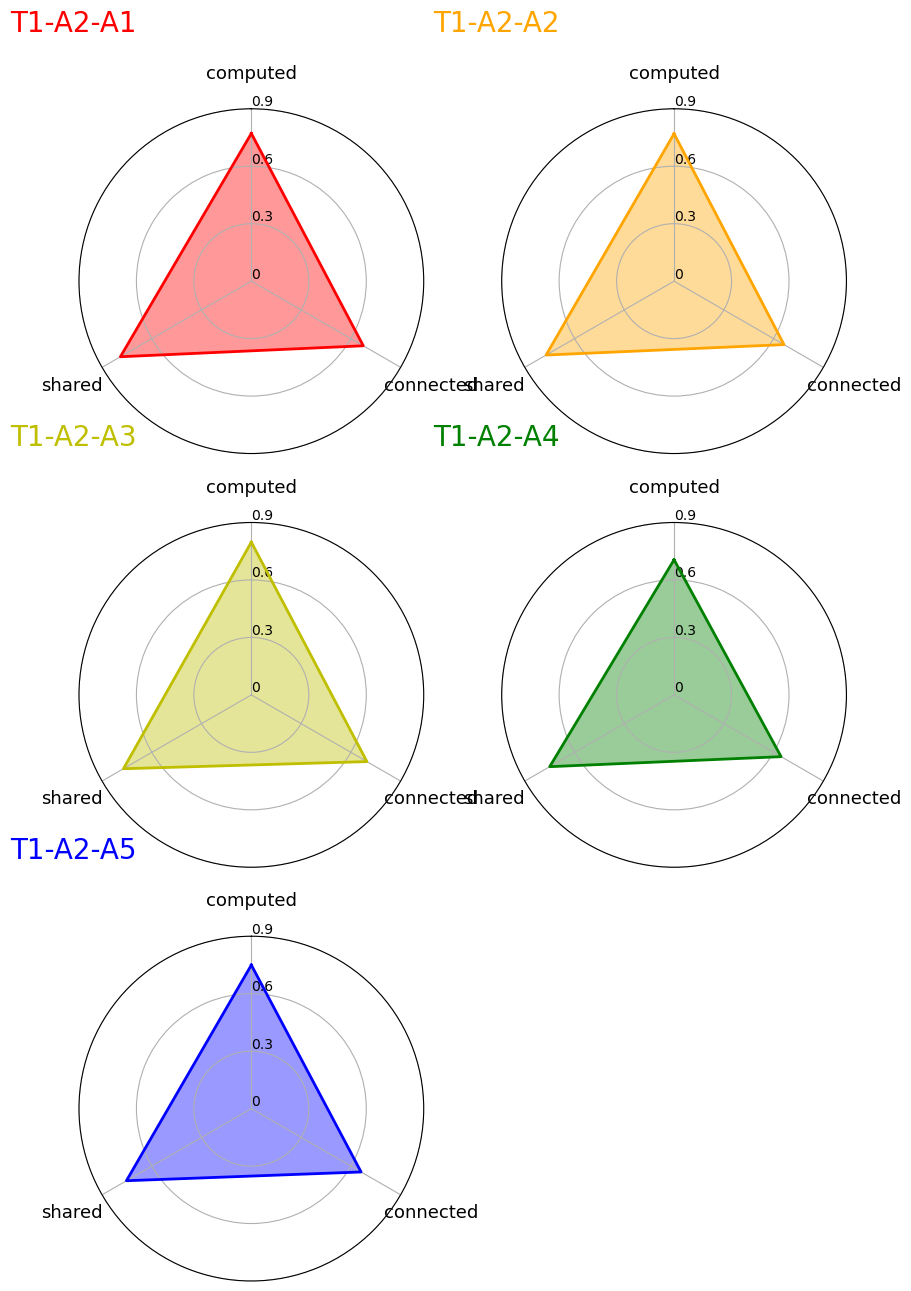

In [45]:
import math

plt.rcParams["figure.figsize"] = (10, 300)


## 따로 그리기
labels = result.columns
num_labels = len(labels)
    
angles = [x/float(num_labels)*(2*math.pi) for x in range(num_labels)] ## 각 등분점
angles += angles[:1] ## 시작점으로 다시 돌아와야하므로 시작점 추가

for i in range(len(result)):
    data = result.iloc[i].tolist()
    data += data[:1]

    ax = plt.subplot(56,2,i+1, polar=True)
    ax.set_theta_offset(math.pi / 2) ## 시작점
    ax.set_theta_direction(-1) ## 그려지는 방향 시계방향

    plt.xticks(angles[:-1], labels, fontsize=13) ## x축 눈금 라벨
    ax.tick_params(axis='x', which='major', pad=15) ## x축과 눈금 사이에 여백을 준 
    ax.set_rlabel_position(0) ## y축 각도 설정(degree 단위)
    plt.yticks([0,0.3,0.6,0.9],['0','0.3','0.6','0.9'], fontsize=10) ## y축 눈금 설정
    plt.ylim(0,0.9)
    ax.plot(angles, data, color=color[i], linewidth=2, linestyle='solid') ## 레이더 차트 출력
    ax.fill(angles, data, color=color[i], alpha=0.4) ## 도형 안쪽에 색을 채워준다.
    
    plt.title(result.index[i], size=20, color=color[i],x=-0.2, y=1.2, ha='left') ## 타이틀은 캐릭터 클래스로 한다.